# Complaint Routing Model

#### by Jeffrey Strickland, Ph.D.
#### 12 August 2019

## Introduction

### Goal: route complaints to the proper researched team based on product groupings. 

The business unit receives complaintsin the form of free text and wants to route the complaints to the wants to route the complaints to one of seven different depaertments (product_group name in the daata parenthesis:.
	1. Bank account or service (bank_servie)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Money Transfers (money_transfers)
	7. Mortgage (mortgange)

We have obtained a data set wiith 286,362 records that contains complaint text (text), a message identifier (complaint_id) and a verified correct complaint department product_group).

### Methodology

- We created three differnet classification models for comparison:

    - Naive Bayes
    - Classification Tree
    - Random Forest

- For of natural language processing (NLP) we chose the bag-of-words method.

## Load Required Packages

In [1]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#String
import string

from matplotlib import pyplot as plt
# Allow plots in Notebook
%matplotlib inline

## Optional Packages

In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import seaborn as sns
#nltk.download('punkt')
#nltk.download('wordnet')

### Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [3]:
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
df = dta[['complaint_id','product_group','text']]
corps = dta[['product_group','text']]

### Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame.

In [4]:
list(df), df.shape

(['complaint_id', 'product_group', 'text'], (263644, 3))

In [5]:
df.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acco...
2,2657456,bank_service,in nj opened a business account without author...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


## Prepare a Frequency Distribution

The next step consist of plotting the frequency of complaints for each product group and plotting the word counts

In [7]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]

In [9]:
# Returns that complaint frequencies for each product group
credit_reporting_len, mortgage_len, bank_service_len, loan_len, credit_card_len, mortgage_len

(81232, 40281, 20071, 31036, 29553, 40281)

In [10]:
df.groupby('product_group').complaint_id.count()

product_group
bank_service        20071
credit_card         29553
credit_reporting    81232
debt_collection     61471
loan                31036
mortgage            40281
Name: complaint_id, dtype: int64

## Plotting the Data

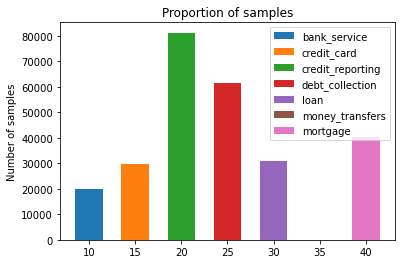

In [11]:
# Sets up the data for construct the frequency distribution (bar chart)
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(15,credit_card_len,3, label="credit_card")
plt.bar(20,credit_reporting_len,3, label="credit_reporting")
plt.bar(25,debt_collection_len,3, label="debt_collection")
plt.bar(30,loan_len,3, label="loan")
plt.bar(35,money_transfers_len,3, label="money_transfers")
plt.bar(40,mortgage_len,3, label="mortgage")
plt.legend()
plt.ylabel('Number of samples')
plt.title('Proportion of samples')
plt.show()

## Store Product Group Data

The next step, and optional one, is to store the data for each product group into its own object for later use (potentially)

In [12]:
bks = df[df.product_group=="bank_service"]["text"].values
mtg = df[df.product_group=="mortgage"]["text"].values
crp = df[df.product_group=="credit_reporting"]["text"].values
ccd = df[df.product_group=="credit_card"]["text"].values
lon = df[df.product_group=="loan"]["text"].values
dct = df[df.product_group=="debt_collection"]["text"].values
mts = df[df.product_group=="money_transfers"]["text"].values

## Basic Text Processing Steps:

1. Removal of Punctuation → All the punctuation marks are removed from all the text-snippets (instances or documents) from the dataset (corpus).
2. Removal of Stopwords → Stop-words are usually articles (a, an, the), prepositions (in, on, under, …) and other frequently occurring words that do not provide any key or necessary information. They are removed from all the text-snippets present in the dataset (corpus).
3. Returns a "clean" version of the text.

In [13]:
X = corps['text']

In [14]:
y = corps['product_group']

## Label Encoding of Classes:

- As this is a classification problem, here classes are the 7 product groups as mentioned. In our dataset, the labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). 
- These are label encoded to make them numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [15]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
#y = corps['product_group']
#X = corps['text']
labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y)

In [16]:
print(labelencoder.fit_transform(y))

[0 0 0 ... 5 5 5]


In [17]:
def text_prep(tex):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in tex if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Word Cloud Visualization:

We developed the word clouds as follows:

- Product groups have their own unique words and phrases, as well as some common ones
- visualization of the mostly-used words to the least-used words for the product groups can be demonstrated
- Seven text snippets, each belonging to the seven product groups, respectively, can render a Word Cloud

In [18]:
# Importing necessary libraries
from PIL import Image
from wordcloud import WordCloud

X = df['text']

wordcloud0 = WordCloud().generate(X[0]) # for bank_service
wordcloud1 = WordCloud().generate(X[1]) # for credit_card
wordcloud2 = WordCloud().generate(X[2]) # for credit_reporting 
wordcloud3 = WordCloud().generate(X[3]) # for debt_collection 
wordcloud4 = WordCloud().generate(X[4]) # for loan
wordcloud6 = WordCloud().generate(X[6]) # for mortgage


bank_service


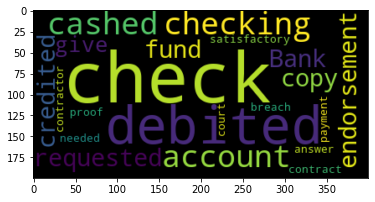

In [19]:
#print(X[0])
print(df['product_group'][0])
plt.imshow(wordcloud0, interpolation='bilinear')
plt.show()

credit_card


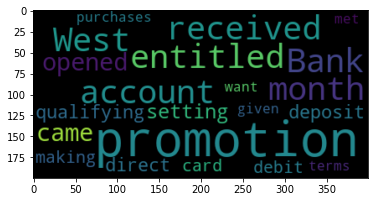

In [20]:
#print(X[22100])
print(df['product_group'][22100])
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()

credit_card


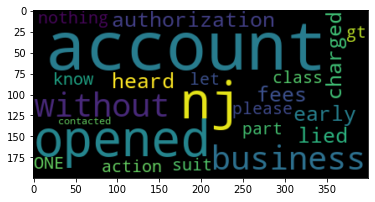

In [21]:
#print(X[42000])
print(df['product_group'][42000])
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()

debt_collection


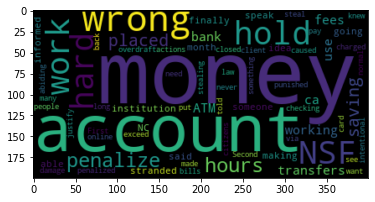

In [22]:
#print(X[152100])
print(df['product_group'][152100])
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()

loan


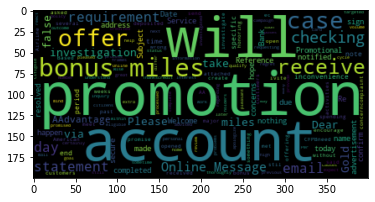

In [23]:
#print(X[199100])
print(df['product_group'][199100])
plt.imshow(wordcloud4, interpolation='bilinear')
plt.show()

mortgage


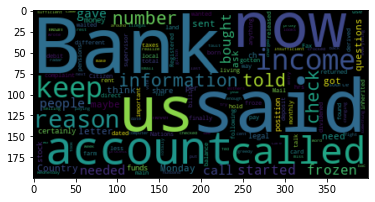

In [25]:
#print(X[237100])
print(df['product_group'][237100])
plt.imshow(wordcloud6, interpolation='bilinear')
plt.show()

## Natural Language Processing (NLP)
In this section we will examine how various natural language processing techniques can provide productive insigts into large collections of text data. In this instance, we continue to analyze the complaint data but with much more robust measures and results. As we have already posed, NLP is the process of turning human speech (usually in written form) into language a computer can understand (numerical) using a program, extracting information from the numerical representation of the lanuage, and turning it back into informative human language.

Here, will make better use of the power of Python and supporting packages, like Skikit-Learn (sklearn). These 'utilities" allow use to take a given text or lollrction of texts, a corpus), remove punctuation, remove white-spaces, convert to lower case, remove common words that yield no information (stpwords) to produce a "clean" version of the text we want to analyze. we will begin by discussing stopwords.

### Lemmatization
Inflected forms of a word are known as lemma. For example, "studying," "studied" are inflected forms or lemma of the word study which is the root word. So, the lemma of a word are grouped under the single root word. This is done to make the vocabulary of words in the corpus contain distinct words only.

Lemmatization is the process of converting a word to its base form. Lemmatization igoes beyond stemming, since lemmatization considers the context and converts the word to its meaningful base form--stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

### Stopwords
A stop word or stopword is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

There are several different ways to process text for stopwords with Python, including the Natural Language Tool Kit (NLTK) and Skikit-Learn (SKLearn). We could also build our own list and implement it by wring python code to remove stopwords using our list, of adapting a list and adding or taking from it for our use. However, processing text for stopwords is not simply a matter of pressing the Run button.

The are many existing stopwords lists and in many languages. In at least one of these lists is the word "computer," a word you may not want to remove, when analyzing text about competing technologies. Likewise, with save when analyzing retail banking issues. Stopwords from Skikit-Learn can be called after importing them, while NTLK stopwords are called within the CountVeterizor()function, which we will get to later in this section.

When we invoke stopwords with CountVectorizer, one of the arguments is, stopwords = None, as the default. If we want English stopwords, we merely add the argument, stopwords = 'english'.

In [26]:
# Importing necessary libraries
# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords

We will defer implementing the removal of stopwords until our discussion of CountVectorizer. For now, let's look at a list of stopwords I adapted from R.

In [27]:
stopwords = pd.read_csv("D:/Documents/Data/english_stopwords.txt")
print(stopwords)

Empty DataFrame
Columns: ['i',  'll',  'me',  'my',  'myself',  'we',  'our',  'ours',  'ourselves',  'you',  "you're",  "you've",  "you'll",  "you'd",  'your',  'yours',  'yourself',  'yourselves',  'he',  'him',  'his',  'himself',  'she',  "she's",  'her',  'hers',  'herself',  'it',  "it's",  'its',  'itself',  'they',  'them',  'their',  'theirs',  'themselves',  'what',  'which',  'who',  'whom',  'this',  'that',  "that'll",  'these',  'those',  'am',  'is',  'are',  'was',  'were',  'be',  'been',  'being',  'have',  'has',  'had',  'having',  'do',  'does',  'did',  'doing',  'a',  'an',  'the',  'and',  'but',  'if',  'or',  'because',  'as',  'until',  'while',  'of',  'at',  'by',  'for',  'with',  'about',  'against',  'between',  'into',  'through',  'during',  'before',  'after',  'above',  'below',  'to',  'from',  'up',  'down',  'in',  'out',  'on',  'off',  'over',  'under',  'again',  'further',  'then', ...]
Index: []

[0 rows x 183 columns]


### Features by Vectorization

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [29]:
# Getting trigrams  
vectorizer = CountVectorizer(ngram_range = (2,2), stop_words='english', max_features = 20) 
X1 = vectorizer.fit_transform(X)  
features = (vectorizer.get_feature_names()) 
print("\n\nFeatures : \n", features) 
#print("\n\nX1 : \n", X1.toarray()) 



Features : 
 ['30 days', 'account number', 'checking account', 'collection agency', 'credit bureau', 'credit bureaus', 'credit card', 'credit file', 'credit report', 'credit reporting', 'credit reports', 'credit score', 'customer service', 'debt collection', 'identity theft', 'loan modification', 'phone calls', 'phone number', 'received letter', 'social security']


### Create Train and Test Sets

In [37]:
from sklearn.model_selection import train_test_split
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
corps = dta[['product_group','text']]
X = corps.text
y = corps.product_group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Vectorization 
Vectorization is the process of converting data into a mathematical construct, like a vector, that can be easily manipulated without changing its content. Vectorization also speeds up computation. We usually evaluate the efficiency of a program by how fast it can manipulate large data sets in a relatively short time interval. Python uses mathematical functions for fast operations on entire arrays of data without having to write loops, and consequently produce results faster.

#### CountVectorizer
CountVectorizer converts text to word count vectors. It provides a simple way to both tokenize a collection of text documents, like our collection of complaints, and build a vocabulary of frequently used words, where the frequency can range from 1… n, known words. This vocabulary of known words can then be used to encode new related documents for analysis. In this manner, we can use a collection of text (complaints) to predict complaints based on this encoding. In our particular case, we will encode the text in such a manner as to not only predict complaints, but to categorize those complaints as belonging to one of the banks services/products, i.e., loans, credit cards, debt collection, and so on.
Here, we will use CountVectorizer to:
1.	Create an instance of the *CountVectorizer* function
2.	Call the *fit()* function to learn a vocabulary from one or more documents
3.	Call the *transform()* function on one or more documents as needed to encode each as a vector 

The pseudocode for this might appear as:
* Create the transform using vectorizer = CountVectorizer()
* Tokenize and build the vocabulary with vectorizer.fit(text)
* Summarized the results of vectorization using print(vectorizer.vocabulary_) [this function accesses the vocabulary to see what exactly was tokenized ]
* Encode the document with vector = vectorizer.transform(text)
* Summarize the encoded vector using print(vector.shape), print(type(vector)), and print(vector.toarray())

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document, hence the “count” in vectorize. Now, these vectors will contain a lot of zeros, which we call them sparse vectors. However, Python provides an efficient way of handling sparse vectors using the *scipy.sparse* package. So, the vectors returned from a call to *transform()* function are sparse vectors, and we can transform them back to numpy arrays. We can then examine them to better understand what occurs by using the *toarray()* function.



In [34]:
count_vect = CountVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64           #type of the matrix returned by fit_transform() or transform()
)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

MemoryError: 

#### Term Frequency–Inverse Document Frequency
The *TfidfTransformer* function transforms a count matrix to a normalized term frequency (tf) or term frequency times inverse document frequency (tf-idf ) representation. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently. We use this transform because frequently occurring tokens in a given corpus are empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the tf-idf for a term *t* of a document *d* in a document set is *tf-idf(t, d) = tf(t, d) * idf(t)*, and the *idf* is computed as *idf(t) = log [ n / df(t) ] + 1* (if smooth_idf=False), where *n* is the total number of documents in the document set and *df(t)* is the document frequency of *t*; the document frequency is the number of documents in the document set that contain the term *t*. The effect of adding “1” to the idf in the equation above is that terms with zero *idf*, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the *idf* formula above differs from the standard textbook notation that defines the *idf* as *idf(t) = log [ n / (df(t) + 1) ])*.

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(
    norm ='l2',          #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,        #enable inverse-document-frequency reweighting
    smooth_idf=True,     #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,  #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)
X_features = tfidf.fit_transform(X_train)


ValueError: could not convert string to float: 'was offered a trial modification by servicer Carrington accepted the offer The first payment was due in the month of As a member of the received 30 day in the month of None-the-less called Carrington to make the trial modification payment over the phone Carrington refused to take the payment over the phone but instead demanded that send via Because of service explained to Carrington that would have limited access to and faxed Carrington stood firm in their unreasonableness was able to get to a office on but Carrington refused to accept the payment because they claimed it was late Authorized Party representative called Carrington on separate occasions and The purpose of each call was to determine whether or not there was a scheduled foreclosure sale date Each time the Authorized Party Representative was told there was not a foreclosure sale date Carrington completed a foreclosure sale on At the time of the foreclosure sale remained out-of-town due to the mentioned above'

#### TfidfVectorizer
This function converts a collection of raw documents to a matrix of TF-IDF features. It is equivalent to CountVectorizer followed by TfidfTransformer.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    input='corps',            #the input text data or corpus
    encoding='utf-8',         #encoding is used to decode
    decode_error='strict',    #means a UnicodeDecodeError will be raised (other values are ignore and replace) 
    strip_accents='ascii',    #removes accents and perform other character normalization (ascii is the fastest)
    lowercase=True,           #converts all tect to lower case
    tokenizer=word_tokenize,  #default value is None (only applies if analyzer == 'word')
    stop_words='english',     #default value is None (only applies if analyzer == 'word')
    token_pattern=r'\b\w+\b', #string, denoting what constitutes a “token” (only used if analyzer == 'word')
    ngram_range=(1, 3),       #will yield unigrams, bigrams, and trigrams
    analyzer='word',          #feature makeup {‘string’, ‘word’, ‘char’, ‘char_wb’} or callable
    max_df=1.0,               #ignore terms that have a frequency higher than this threshold
    min_df=1,                 #ignore terms that have a frequency lower than this threshold
    max_features = 20,        #build a vocabulary size N or None
    binary=False,             #if True, all non zero counts are set to 1
    dtype= np.int64,          #type of the matrix returned by fit_transform() or transform()
    norm ='l2',               #each output row will have unit norm, either: 'l2', 'l1', or None
    use_idf=True,             #enable inverse-document-frequency reweighting
    smooth_idf=True,          #smooth idf weights by adding one to document frequencies to prevent divison by zero
    sublinear_tf=False,       #apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
)
X_features = tfidf.fit_transform(X_train)

C:\Users\jeff\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [2]:
#Standard packages
import pandas as pd
import numpy as np
import matplotlib

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#String
import string

from matplotlib import pyplot as plt
# Allow plots in Notebook
%matplotlib inline

In [6]:
from sklearn.model_selection import train_test_split
dta = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
corps = dta[['product_group','text']]
X = corps.text
y = corps.product_group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1234)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [8]:
tfidf= TfidfVectorizer(sublinear_tf=True, min_df = 5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(X_train) 
labels = y_train 

MemoryError: 

In [9]:
X_train = tfidf.fit(X_train)
X_test = tfidf.fit(X_test)

MemoryError: 

In [ ]:
bow_transformer=vectorizer.fit(X_train)
text_bow_train=bow_transformer.transform(X_train) #TRAINING DATA
text_bow_test=bow_transformer.transform(X_test) #TEST DATA

#### Product-to-Category and Category-to-Product Definition
If we were just concerned with generating information about complaints, we would not have to perform this step. We would merely call the n-grams from text with the CountVectorizer function. However, we want to encode the text in such a manner that we can identify complaints related to one of the bank services/products. Consequentially, we need to take the complaint about debt collection, and not only tokenize and transform the complaint text, but also assign a number to the category, debt collection. For example, the code we use below assigns 'zero' to the category 'bank services'. By calling the function category_to_id.items(), we can see all the category numeric assignments as shown below.

In [414]:
df = corp
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','text']
df['category_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_group']].values)
df.head()

,product_group,text,category_id
0,bank_service,On check was debited from checking account and...,0
1,bank_service,opened a Bank of the the West account The acc...,0
2,bank_service,in nj opened a business account without autho...,0
3,bank_service,A hold was placed on saving account because in...,0
4,bank_service,Dear CFPBneed to send a major concerncomplaint...,0


Again, by calling the function category_to_id.items(), we can see all the category numeric assignments:

In [376]:
category_to_id.items()

dict_items([('bank_service', 0), ('credit_card', 1), ('credit_reporting', 2), ('debt_collection', 3), ('loan', 4), ('money_transfers', 5), ('mortgage', 6)])

### Naïve  Bayes Classification
Naïve Bayes is a very simple and reliable way to analyze how well text can be used to predict outcomes. In our case, we want to determine if the complaint data can be used to accurately classify and the predict the complaints by back services/product. In other words, can we use the present encoded complaint data to determine if a new complaint is correctly classified as a debt collect complaint, for example.

Here, we envoke yet another Scikit-Learn function, MultinomialNB(). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work, and we assume that here as well. MultinomialNB() has several functions:
* Fit function takes on two arguments: X, y or X-train, y_train when training a model.
* Get_params retrieves the parameters for this estimator.
* Predict function perform classification on an array of test vectors X, i.e., X_test.
* Predict_proba returns the probability estimates for the test vector X.
* Predict_log_proba returns the log-probability estimates for the test vector X
* Score function returns the mean accuracy on the given test data and labels.


In [ ]:
mnb_clf = MultinomialNB(
    alpha=1.0,        #additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
    class_prior=None, #prior probabilities of the classes. If specified, priors are not adjusted according to the data. 
    fit_prior=True    #whether to learn class prior probabilities or not, false = uniform prior will be used.
)

### Pipeline Definition
Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification.

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__', as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to 'passthrough' or None.

A Pipeline provides:
* Convenience and encapsulation: allows us to call fit and predict once on our data to fit a whole sequence of estimators.
* Joint parameter selection: allow us to grid search over parameters of all estimators in the pipeline at once.
* Safety: pipelines help avoid "leaking" statistics from our test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

In [440]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('mnb_clf', MultinomialNB()),
 ])

For our problem, we have already defined CountVectorizer(), TfidfTransformer(), and MultinomialNB(), so we point to those functions with there represenations. Now we can call any of the functionality of these functions simply by calling its representative, e.g., tfidf.fit_transform(X_train)

In [ ]:
text_clf = Pipeline([
     ('vect', count_vect),
     ('tfidf', tfidf),
     ('mnb_clf', mnb_clf),
 ])

In [492]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidff.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'bank_service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'credit_card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. american express
. credit card
# 'credit_reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. credit file
. credit report
# 'debt_collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collection agency
. collect debt
# 'loan':
  . Most correlated unigrams:
. loans
. navient
  . Most correlated bigrams:
. student loans
. student loan
# 'money_transfers':
  . Most correlated unigrams:
. western
. coinbase
  . Most correlated bigrams:
. coinbase account
. western union
# 'mortgage':
  . Most correlated unigrams:
. modification
. mortgage
  . Most correlated bigrams:
. mortgage company
. loan modification


### BOW Preparation

### Bag-of-Words (BOW):

- With Bag-of-Words a vocabulary of words present in the corpus is maintained. 
- These words serve as features for each instance or document (each complaint). 
- Against each word as feature, its frequency in the current document (complaint) is considered. 
- In this way word features are engineered or extracted from the textual data or corpus.

## Feature Engineering using Bag-of-Words:

- Machine Learning Algorithms work only on numeric data. 
- But here, data is present in the form of text only. 
- For that, by some means, textual data needs to be transformed into numeric form. 
- One such approach of doing this, is Feature Engineering. 
- In this approach, numeric features are extracted or engineered from textual data. 
- There are many Feature Engineering Techniques in existence. 
- In this problem, Bag-of-Words Technique of Feature Engineering has been used.

In [ ]:
# Stopword removal  
stop_words = ('english') 
your_list = ['um', 'uh', 'hum', 'oh'] 
for i, line in enumerate(X1_train): 
    X1_train[i] = ' '.join([x for 
        x in nltk.word_tokenize(line) if 
        ( x not in stop_words ) and ( x not in your_list )]) 
      
# Getting trigrams  
vectorizer = CountVectorizer(ngram_range = (1,2)) 
X1 = vectorizer.fit_transform(X1_train)  
features = (vectorizer.get_feature_names()) 
print("\n\nFeatures : \n", features) 
print("\n\nX1 : \n", X1.toarray()) 

# Applying TFIDF 
vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
X2 = vectorizer.fit_transform(X1_train) 
scores = (X2.toarray()) 
print("\n\nScores : \n", scores) 
  
# Getting top ranking features 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0,col] )) 
ranking = pd.DataFrame(data1, columns = ['term','rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords head : \n", words.head(7)) 

In [100]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(187866, 3459788)

In [101]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(187866, 3459788)

In [102]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [103]:
print(clf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [104]:
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(y_train)
print(vectorizer.get_feature_names())

['bank_service', 'credit_card', 'credit_reporting', 'debt_collection', 'loan', 'money_transfers', 'mortgage']


In [105]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [106]:
predicted = clf.predict(X_test_tfidf)

In [107]:
count_vect.vocabulary_.get(u'algorithm')

305402

### Bag-of_words Pipeline

In [108]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', count_vect),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
 ])

In [399]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features1_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature1_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

ValueError: Expected 2D array, got 1D array instead:
array=['30 days' 'account number' 'bank account' 'checking account'
 'collection agency' 'credit bureau' 'credit bureaus' 'credit card'
 'credit file' 'credit report' 'credit reporting' 'credit reports'
 'credit score' 'customer service' 'debt collection' 'identity theft'
 'loan modification' 'phone number' 'received letter' 'social security'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [109]:
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='corps',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        st...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [110]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test) 

0.7091810119979134

In [115]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted,
     target_names=features))

                  precision    recall  f1-score   support

    bank_service       0.94      0.30      0.46      5999
     credit_card       0.84      0.35      0.49      8847
credit_reporting       0.59      0.96      0.73     24445
 debt_collection       0.78      0.77      0.77     18481
            loan       0.96      0.41      0.57      9314
 money_transfers       1.00      0.00      0.01      1422
        mortgage       0.85      0.89      0.87     12006

     avg / total       0.77      0.71      0.68     80514



In [121]:
from sklearn.linear_model import SGDClassifier

svm_clf = Pipeline([
     ('vect', count_vect),
     ('tfidf', TfidfTransformer()),
     ('svm_clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
 ])

svm_clf.fit(X_train, y_train)  

predicted = svm_clf.predict(X_test)
np.mean(predicted == y_test)

0.7927441190351988

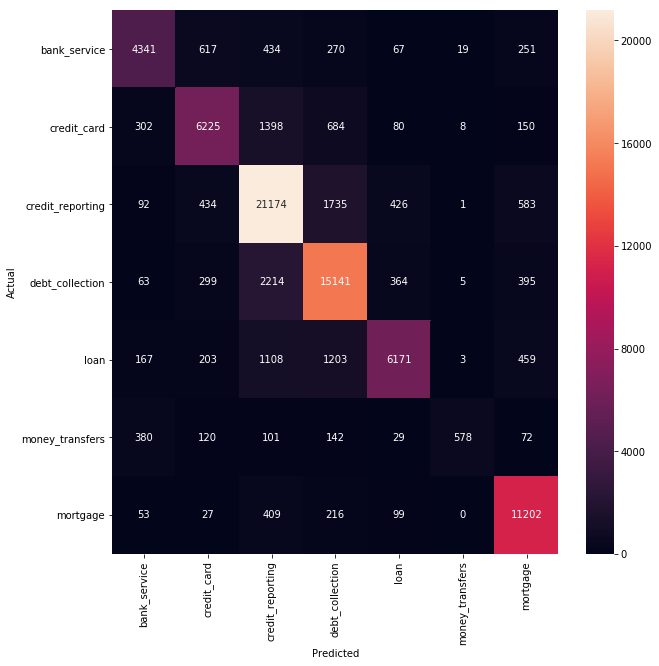

In [81]:
#svm_class = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
features = vectorizer.get_feature_names()
print(metrics.classification_report(y_test, predicted, target_names=features))
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=features, yticklabels=features)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [82]:
print(conf_mat)

[[ 4341   617   434   270    67    19   251]
 [  302  6225  1398   684    80     8   150]
 [   92   434 21174  1735   426     1   583]
 [   63   299  2214 15141   364     5   395]
 [  167   203  1108  1203  6171     3   459]
 [  380   120   101   142    29   578    72]
 [   53    27   409   216    99     0 11202]]


                  precision    recall  f1-score   support

    bank_service       0.83      0.70      0.76      5999
     credit_card       0.82      0.66      0.73      8847
credit_reporting       0.74      0.90      0.81     24445
 debt_collection       0.79      0.78      0.78     18481
            loan       0.89      0.60      0.72      9314
 money_transfers       0.94      0.38      0.54      1422
        mortgage       0.84      0.94      0.89     12006

     avg / total       0.80      0.79      0.79     80514



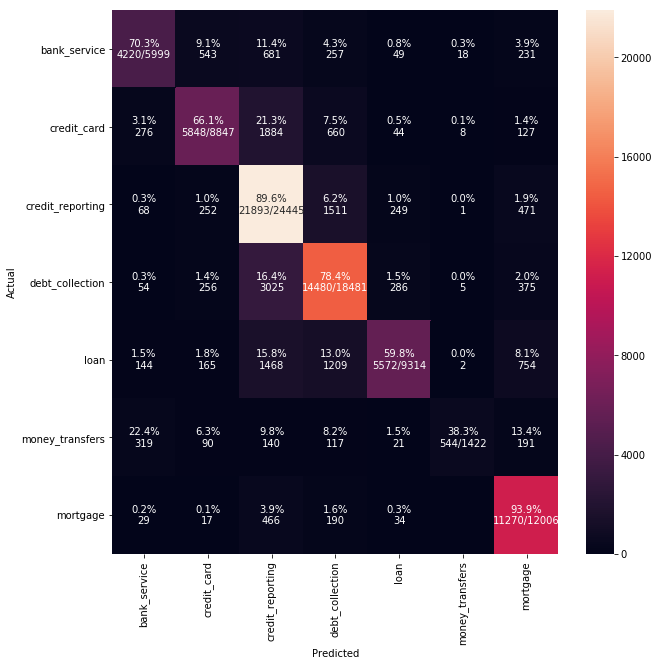

In [122]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

result = svm_clf.score(X_test, y_test)
y_pred = svm_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=features))

cm_analysis(y_test, y_pred, svm_clf.classes_, ymap=None, figsize=(10,10))

In [83]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(10,10))

NameError: name 'model' is not defined

In [133]:
from io import StringIO
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)

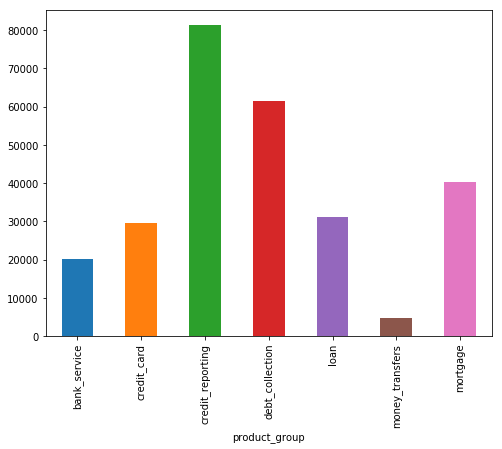

In [134]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
corps.groupby('product_group').text.count().plot.bar(ylim=0)
plt.show()

In [195]:
# Getting trigrams  
vectorizer = CountVectorizer(ngram_range = (1,2)) 
X1 = count_vect.fit_transform(X_train)
#X1 = vectorizer.fit_transform(X_test)  
features = (vectorizer.get_feature_names()) 
print("\n\nFeatures : \n", features) 
print("\n\nX1 : \n", X1.toarray()) 

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [187]:
from sklearn.feature_selection import chi2
import numpy as np
labels = corps.complaint_id
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

ValueError: Expected 2D array, got 1D array instead:
array=['bank_service' 'credit_card' 'credit_reporting' 'debt_collection' 'loan'
 'money_transfers' 'mortgage'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [188]:
from sklearn.feature_selection import chi2
N = 2
category_id = df.complaint_id
labels = df.complaint_id
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

ValueError: Expected 2D array, got 1D array instead:
array=['bank_service' 'credit_card' 'credit_reporting' 'debt_collection' 'loan'
 'money_transfers' 'mortgage'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [154]:
feature_names = np.array(vectorizer.get_feature_names())
feature_names

array(['bank_service', 'credit_card', 'credit_reporting',
       'debt_collection', 'loan', 'money_transfers', 'mortgage'],
      dtype='<U16')

In [152]:
bow_transformer=CountVectorizer(analyzer=text_prep).fit(X_train)

NameError: name 'text_prep' is not defined

In [26]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [27]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

In [28]:
print(text_bow_train)

  (0, 51840)	1
  (0, 52120)	1
  (0, 59641)	1
  (0, 65939)	1
  (0, 68315)	2
  (0, 70586)	1
  (0, 73127)	1
  (0, 78900)	1
  (0, 83366)	1
  (0, 85115)	1
  (0, 90335)	1
  (0, 93394)	1
  (0, 93510)	1
  (0, 94403)	1
  (0, 96701)	1
  (0, 102012)	1
  (0, 103789)	2
  (0, 109404)	1
  (0, 119580)	1
  (0, 124540)	2
  (0, 131716)	1
  (1, 3108)	1
  (1, 7197)	5
  (1, 11054)	1
  (1, 21045)	3
  :	:
  (187865, 86804)	2
  (187865, 87836)	1
  (187865, 92627)	2
  (187865, 92691)	1
  (187865, 97906)	1
  (187865, 97932)	1
  (187865, 99784)	1
  (187865, 100147)	1
  (187865, 102847)	3
  (187865, 102857)	1
  (187865, 109677)	1
  (187865, 110808)	1
  (187865, 111362)	1
  (187865, 112207)	2
  (187865, 112644)	1
  (187865, 113195)	1
  (187865, 115842)	1
  (187865, 116223)	2
  (187865, 117159)	1
  (187865, 117548)	2
  (187865, 118245)	1
  (187865, 120968)	1
  (187865, 128601)	2
  (187865, 129305)	1
  (187865, 130560)	1


In [29]:
print(text_bow_test)

  (0, 136)	1
  (0, 6382)	1
  (0, 7011)	1
  (0, 14084)	2
  (0, 14355)	2
  (0, 18348)	2
  (0, 21454)	1
  (0, 21490)	1
  (0, 22739)	1
  (0, 37725)	3
  (0, 40755)	1
  (0, 42903)	1
  (0, 51280)	1
  (0, 51584)	1
  (0, 52311)	7
  (0, 52475)	11
  (0, 54600)	2
  (0, 55129)	1
  (0, 55657)	1
  (0, 56119)	3
  (0, 56131)	1
  (0, 57062)	2
  (0, 57271)	1
  (0, 57530)	1
  (0, 57615)	1
  :	:
  (80513, 107877)	1
  (80513, 109645)	1
  (80513, 110131)	1
  (80513, 111639)	1
  (80513, 112629)	2
  (80513, 114956)	1
  (80513, 115747)	1
  (80513, 116151)	1
  (80513, 116223)	1
  (80513, 117380)	1
  (80513, 119412)	1
  (80513, 119417)	2
  (80513, 119562)	1
  (80513, 119580)	1
  (80513, 123573)	1
  (80513, 125800)	2
  (80513, 126035)	1
  (80513, 128126)	1
  (80513, 128297)	1
  (80513, 128362)	1
  (80513, 129305)	1
  (80513, 130809)	1
  (80513, 131377)	1
  (80513, 131846)	1
  (80513, 132158)	1


## Training the Multinomial Naive Bayes Model:

Multinomial Naive Bayes Algorithm (Classifier) has been used as the Classification Machine Learning Algorithm [1].

In [30]:
from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [31]:
X_train.size, text_bow_train.size, y_train.size

(187866, 11571246, 187866)

In [32]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
clf_bayes = MultinomialNB()

# training the model...
clf_bayes = clf_bayes.fit(text_bow_train, y_train)

In [33]:
clf_bayes.score(text_bow_train, y_train)

0.8269032182513067

### Model Performance Analysis:

#### Training Accuracy

In [34]:
X_train.size, text_bow_train.size, y_train.size

(187866, 11571246, 187866)

In [35]:
X_test.size, text_bow_test.size, y_test.size

(80514, 4941354, 80514)

In [36]:
bayes_score = clf_bayes.score(text_bow_test, y_test)
bayes_score

0.8131132473855479

#### Validation Accuracy

In [37]:
bayes_val_score = clf_bayes.score(text_bow_test, y_test)
bayes_val_score

0.8131132473855479

The cross-validation score is very close to the model score, 80.99 versus 82.44. The naive Bayes model is a good fit of the data and will produce good predictions.


### Precision, Recall and F1–Score

In [38]:
# Importing necessary libraries
from sklearn.metrics import classification_report
 
# getting the predictions of the Validation Set...
bayes_preds = clf_bayes.predict(text_bow_test)

# getting the Precision, Recall, F1-Score
print(classification_report(y_test,bayes_preds))

                  precision    recall  f1-score   support

    bank_service       0.76      0.82      0.79      5999
     credit_card       0.73      0.77      0.75      8847
credit_reporting       0.83      0.83      0.83     24445
 debt_collection       0.83      0.77      0.80     18481
            loan       0.74      0.78      0.76      9314
 money_transfers       0.90      0.58      0.70      1422
        mortgage       0.90      0.92      0.91     12006

     avg / total       0.81      0.81      0.81     80514



### Naive Bayes Predictions

In [39]:
bayes_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype='<U16')

In [40]:
clf_bayes.predict_proba(text_bow_test)

array([[1.96163636e-64, 3.68264399e-54, 1.00000000e+00, ...,
        1.82289745e-69, 4.34615419e-98, 1.81945327e-69],
       [9.86485846e-07, 9.98411675e-01, 1.58729751e-03, ...,
        1.67364088e-11, 9.71595187e-13, 2.30865676e-13],
       [1.39701122e-26, 9.66237698e-24, 1.00000000e+00, ...,
        2.49981276e-22, 1.70599217e-32, 7.00265283e-31],
       ...,
       [2.09212552e-04, 9.99790787e-01, 2.68461844e-18, ...,
        6.78341027e-14, 9.68134781e-16, 2.61362855e-15],
       [1.41957712e-01, 5.85232805e-06, 1.46095100e-08, ...,
        1.85685276e-12, 1.38358592e-19, 4.17527362e-16],
       [5.33449772e-58, 2.38661955e-61, 2.27497748e-24, ...,
        1.22994823e-47, 1.25568848e-84, 8.46819882e-14]])

### Confusion Matrix

In [41]:
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 4925   517   199    90    71    62   135]
 [  561  6800   858   351   208    18    51]
 [  152  1015 20331  1549   968     5   425]
 [  113   530  2228 14273   995     6   336]
 [  173   267   679   711  7268     2   214]
 [  422   115    11    20    21   818    15]
 [  116   110   321   162   244     1 11052]]


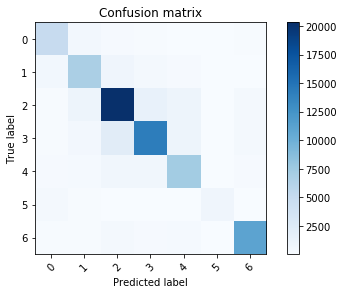

In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_test,bayes_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5,6])

Normalized confusion matrix
[[8.21e-01 8.62e-02 3.32e-02 1.50e-02 1.18e-02 1.03e-02 2.25e-02]
 [6.34e-02 7.69e-01 9.70e-02 3.97e-02 2.35e-02 2.03e-03 5.76e-03]
 [6.22e-03 4.15e-02 8.32e-01 6.34e-02 3.96e-02 2.05e-04 1.74e-02]
 [6.11e-03 2.87e-02 1.21e-01 7.72e-01 5.38e-02 3.25e-04 1.82e-02]
 [1.86e-02 2.87e-02 7.29e-02 7.63e-02 7.80e-01 2.15e-04 2.30e-02]
 [2.97e-01 8.09e-02 7.74e-03 1.41e-02 1.48e-02 5.75e-01 1.05e-02]
 [9.66e-03 9.16e-03 2.67e-02 1.35e-02 2.03e-02 8.33e-05 9.21e-01]]


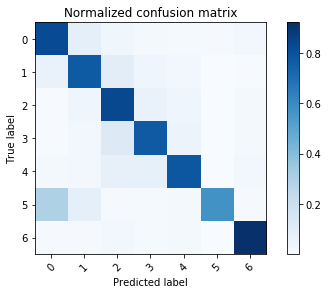

In [43]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, classes=[0,1,2,3,4,5,6],title='Normalized confusion matrix')
plt.show()

# Training the Classification Tree Model

In [48]:
from sklearn import tree
clf_class = tree.DecisionTreeClassifier()
clf_class = clf_class.fit(text_bow_train, y_train)

In [49]:
clf_class

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Classification Tree Scores

In [50]:
from sklearn import tree

In [51]:
tree_score = clf_class.score(text_bow_train, y_train)
tree_score

0.9991802667859006

In [52]:
tree_val_score = clf_class.score(text_bow_test, y_test)
tree_val_score

0.7502794545048066

The cross-validation score is much lower than the model score, 75.83 versus 99.91. The classificaton tree model is over-fitting the data and will produce numerous false positives.


### Classification Tree Predictions

In [53]:
tree_preds = clf_class.predict(text_bow_test)
tree_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [54]:
clf_class.predict_proba(text_bow_test)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Tree Summary

According to the Performance Analysis, we can conclude that this model may be overfitting the data, given th significant difference wetween train and test scores. 
- Train: 99.91% 
- Test: 75.94%

# Training the Random Forest Model

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [56]:
clf_rf = RandomForestClassifier(n_estimators=100) # initialize
clf_rf.fit(text_bow_train, y_train) # fit the data to the algorithm

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Random Forest Model Scores

In [64]:
forest_score = clf_rf.score(text_bow_train, y_train)
forest_score

0.9991802667859006

In [65]:
forest_val_score = clf_rf.score(text_bow_test, y_test)
forest_val_score

0.8230618277566635

In [59]:
clf_rf.get_params(clf_rf.fit)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Forest Predictions

In [60]:
forest_preds = clf_rf.predict(text_bow_test)
forest_preds[0:10]

array(['credit_reporting', 'credit_card', 'credit_reporting',
       'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
       'debt_collection', 'credit_reporting', 'credit_reporting'],
      dtype=object)

In [61]:
clf_rf.predict_proba(text_bow_test)[0:10]

array([[0.03, 0.09, 0.57, 0.24, 0.04, 0.  , 0.03],
       [0.04, 0.39, 0.21, 0.18, 0.08, 0.01, 0.09],
       [0.01, 0.02, 0.88, 0.06, 0.03, 0.  , 0.  ],
       [0.05, 0.47, 0.17, 0.21, 0.02, 0.02, 0.06],
       [0.06, 0.09, 0.15, 0.08, 0.1 , 0.03, 0.49],
       [0.  , 0.02, 0.91, 0.04, 0.01, 0.  , 0.02],
       [0.12, 0.2 , 0.48, 0.11, 0.04, 0.03, 0.02],
       [0.03, 0.11, 0.34, 0.46, 0.05, 0.  , 0.01],
       [0.03, 0.09, 0.47, 0.26, 0.08, 0.02, 0.05],
       [0.08, 0.07, 0.58, 0.1 , 0.03, 0.  , 0.14]])

### Random Forest Summary

The random forest model is probably over-fitting the data and will produce numerous false positives. The cross-validation score is much lower than the model score. 
- Train: 99.91. 
- Test: 82.45  

# Model Comparisons

In [62]:
bayes_preds[0:20], tree_preds[0:20], forest_preds[0:20]

(array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'bank_service',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype='<U16'),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_collection', 'credit_reporting', 'loan',
        'credit_card', 'loan', 'credit_reporting', 'mortgage', 'mortgage',
        'loan'], dtype=object),
 array(['credit_reporting', 'credit_card', 'credit_reporting',
        'credit_card', 'mortgage', 'credit_reporting', 'credit_reporting',
        'debt_collection', 'credit_reporting', 'credit_reporting',
        'bank_service', 'debt_col

In [66]:
bayes_score, bayes_val_score, tree_score, tree_val_score, forest_score, forest_val_score

(0.8131132473855479,
 0.8131132473855479,
 0.9991802667859006,
 0.7502794545048066,
 0.9991802667859006,
 0.8230618277566635)

# Conclusion

- The Classification and Random Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

## Backup Material

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
comp=bow_transformer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])
print(model.predict(comp))

['debt_collection']


In [49]:
comp2=bow_transformer.transform(["someone stole my credit card and used it at walmart. I received a credit card alert on my mastercard."])
print(model.predict(comp2))

['credit_card']


In [88]:
comp3=bow_transformer.transform(["I am trying tos get a second morgage. the rate on my original mortgage is high."])
print(model.predict(comp3))

['mortgage']


In [89]:
comp3=bow_transformer.transform(["I wanted to get a loan to purchase a new car, but they said my credit score was too low due to other outstanding loans. I don't see what the big deal is with having other loans."])
print(model.predict(comp3))

['loan']


## Multi-layer Perceptron Classifier

In [90]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
mlpc.fit(text_bow_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### MLPClassifier Scores
#### *Training Accuracy*

In [91]:
MLPC_score = mlpc.score(text_bow_train, y_train)
MLPC_score

0.9191711113240288

#### Validation Accuracy

In [92]:
MLPC_val_score = mlpc.score(text_bow_test, y_test)
MLPC_val_score

0.8239064013711901

The cross-validation score is very close to the model score, 88.21 versus 81.87. The naive Bayes model is a good fit of the data and will produce good predictions.

## Multi-class Support Vector Machine

In [44]:
from sklearn import svm
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### SVM Scores
#### *Training Accuracy*

In [45]:
SVM_score = svm_class.score(text_bow_train, y_train)
SVM_score

0.9570012668604218

#### *Validation Accuracy*

In [46]:
SVM_val_score = svm_class.score(text_bow_test, y_test)
SVM_val_score

0.8096852721265867

#### *SVM Predictions*

In [47]:
svm_pred = svm_class.predict(text_bow_test)
svm_pred

array(['credit_reporting', 'credit_card', 'credit_reporting', ...,
       'credit_card', 'debt_collection', 'debt_collection'], dtype=object)

In [48]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, svm_pred)

In [50]:
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)
df.head()

,product_group,complaint_id,text
0,2815595,0,On check was debited from checking account and...
1,2217937,1,opened a Bank of the the West account The acc...
2,2657456,2,in nj opened a business account without autho...
3,1414106,3,A hold was placed on saving account because in...
4,1999158,4,Dear CFPBneed to send a major concerncomplaint...


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
features = tfidf_transformer.fit_transform(text_bow_train)
labels = text_bow_train

In [60]:
#svm_class = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train)
y_pred = svm_class.predict(text_bow_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.product_group.values, yticklabels=category_id_df.product_group.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
plt.show()

The cross-validation score is very close to the model score, 94.32 versus 81.25. The naive Bayes model is a good fit of the data and will produce good predictions.


# PART II. Multi-Class Text Classification

## 7. Data Exploration and Preparation

As we stated in paragraph 3, we perform Multi-Class Text Classification
using a number of models, including a support vector machine (SVM),
multinomial Bayes classification mode, random forest classification
model, and a multinomial logistic regression model. Our goal here is to
get a better outcome than afforded by our initial analysis (Part I).

### 7.1. Data Exploration

Before diving into training our machine learning models, we take another
look at the distribution of complaints in each class using a histogram.


In [ ]:
dfm = df[['product_group','complaint_id','text']]
dfm.head(10)

In [71]:
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group','complaint_id', 'text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)
df.head()

,product_group,complaint_id,text
0,2815595,0,On check was debited from checking account and...
1,2217937,1,opened a Bank of the the West account The acc...
2,2657456,2,in nj opened a business account without autho...
3,1414106,3,A hold was placed on saving account because in...
4,1999158,4,Dear CFPBneed to send a major concerncomplaint...


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(20,credit_card_len,3, label="credit_card")
plt.bar(30,credit_reporting_len,3, label="credit_reporting")
plt.bar(40,debt_collection_len,3, label="debt_collection")
plt.bar(50,loan_len,3, label="loan")
plt.bar(60,money_transfers_len,3, label="money_transfers")
plt.bar(70,mortgage_len,3, label="mortgage")
df.groupby('complaint_id').text.count().plot.bar(ylim=0)
plt.legend()
plt.show()

### 7.2. Data Preparation

As before, we first prepare the text for analysis by Vectorizing it,
although we do it here differently in order to use the text in our
various models more effectively.

In [99]:
filtered_text = ["".join(item) for item in X.astype(str)]

In [128]:
    from nltk.corpus import stopwords 
    from nltk.tokenize import word_tokenize 
    X1 = X.astype(str)
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in X1 if not w in stop_words] 
    filtered_sentence = [] 
    for w in X1: 
       if w not in stop_words: 
          filtered_sentence.append(w) 
    filtered_sentence

["On check was debited from checking account and this check cashed by requested a copy of the endorsement of whom the fund was credited to Bank can't give me satisfactory answer since this contractor breach of contract that needed proof of payment in court ",
 ' opened a Bank of the the West account The account came with a promotion The promotion was get $100 for setting up a qualifying direct deposit have received that promotion The other promotion was get $50 for making debit card purchases each month for 2 months have met the terms for the $50 promotion and have not received the promotion that am entitled to want the $50 that am entitled to that Bank of the West has not given me ',
 ' in nj opened a business account without authorization in early and also lied about fees not being charged on a  account have heard nothing about this please let me know how gt part of class action suit NO ONE has contacted me',
 'A hold was placed on saving account because institution said was making m

In [129]:
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in filtered_sentence]
print(stripped[:100])

['On check was debited from checking account and this check cashed by requested a copy of the endorsement of whom the fund was credited to Bank cant give me satisfactory answer since this contractor breach of contract that needed proof of payment in court ', ' opened a Bank of the the West account The account came with a promotion The promotion was get 100 for setting up a qualifying direct deposit have received that promotion The other promotion was get 50 for making debit card purchases each month for 2 months have met the terms for the 50 promotion and have not received the promotion that am entitled to want the 50 that am entitled to that Bank of the West has not given me ', ' in nj opened a business account without authorization in early and also lied about fees not being charged on a  account have heard nothing about this please let me know how gt part of class action suit NO ONE has contacted me', 'A hold was placed on saving account because institution said was making more than

In [102]:
exclude = set(string.punctuation)
clean_text = ''.join(ch for ch in filtered_sentence if ch not in exclude)


In [104]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
#features = tfidf_transformer.fit_transform(X_train_counts)
#labels = X_train

In [50]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
features = tfidf_transformer.fit_transform(text_bow_train)
labels = text_bow_train

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


#### bow_transformer=CountVectorizer(analyzer=text_prep).fit(X_train)

transforming into Bag-of-Words and hence textual data to numeric.

#### text_bow_train=*bow_transformer*.transform(X_train)

In [51]:
print(features)

  (0, 131716)	0.09956979088846268
  (0, 124540)	0.21960433275731117
  (0, 119580)	0.15578830935582882
  (0, 109404)	0.18360124108436732
  (0, 103789)	0.2274950079324384
  (0, 102012)	0.16565055661433464
  (0, 96701)	0.29409705534222214
  (0, 94403)	0.1375313275103273
  (0, 93510)	0.17402378354819137
  (0, 93394)	0.1180298101078346
  (0, 90335)	0.27447622824595375
  (0, 85115)	0.19808763455418318
  (0, 83366)	0.24618954997752404
  (0, 78900)	0.32317112241613805
  (0, 73127)	0.2486592572566461
  (0, 70586)	0.30777153654776507
  (0, 68315)	0.2525529891112439
  (0, 65939)	0.18750130500244452
  (0, 59641)	0.21654839750525426
  (0, 52120)	0.21964283266922527
  (0, 51840)	0.15750421936120476
  (1, 131716)	0.054606274712806914
  (1, 130506)	0.051445877120501846
  (1, 129832)	0.08254117888738081
  (1, 128289)	0.04897826063376147
  :	:
  (187865, 73443)	0.08024059019131015
  (187865, 70257)	0.255520061921631
  (187865, 69864)	0.10575073682991896
  (187865, 69453)	0.10658616982348638
  (187865, 6

### 7.3. Checking the Data

Here we choose to check our vectorized data using Chi-Square testing and
examining unigrams and bigrams for each SCRA Issue (class). This will
give us an idea of the most important words and pair of words in the
text as they pertain to classification of complaints. Note that ``Well
Fargo'' is a bigram for ``Excessive Interest'' Perhaps suprisingly,
``"Well Fargo'' appears in the transcripts of USAA SCRA calls, probably
due to the high interest rates they were demanding from service members.
As a result of these violations, we should take care to note these as we
discuss SCRA with our members, who may have formally sought loans from
Wells Fargo, for instance. The other unigrams and bigrams should be
apparent.


## 8. Model Development and Execution

Here we prepare to implement and run our four models.

### 8.1. Model Preparation

As before, we define training and test sets and prepare them for a BOW
analysis with our models.


In [74]:
corps.head(5)

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acc...
2,2657456,bank_service,in nj opened a business account without autho...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


In [ ]:
labelencoder = LabelEncoder()
yL = labelencoder.fit_transform(y_train)

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

bow_transformer=CountVectorizer(analyzer=text_prep).fit(X_train)
#count_vect = CountVectorizer()
count_vect = bow_transformer

#### transforming into Bag-of-Words and hence textual data to numeric.

text_bow_train=*bow_transformer*.transform(X_train)
X_train_counts = bow_transformer.fit_transform(X_train)

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train, y_train)

#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [91]:
from io import StringIO
df = corps
df = df[pd.notnull(df['product_group'])]
df.columns = ['product_group', 'complaint_id','text']
df['complaint_id'] = df['product_group'].factorize()[0]
category_id_df = df[['product_group', 'complaint_id']].drop_duplicates().sort_values('complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['complaint_id', 'product_group']].values)
df.head()

,product_group,complaint_id,text
0,2815595,0,On check was debited from checking account and...
1,2217937,1,opened a Bank of the the West account The acc...
2,2657456,2,in nj opened a business account without autho...
3,1414106,3,A hold was placed on saving account because in...
4,1999158,4,Dear CFPBneed to send a major concerncomplaint...


In [115]:
labels = df.complaint_id 
labels

0              0
1              1
2              2
3              3
4              4
5              5
6              6
7              7
8              8
9              9
10            10
11            11
12            12
13            13
14            14
15            15
16            16
17            17
18            18
19            19
20            20
21            21
22            22
23            23
24            24
25            25
26            26
27            27
28            28
29            29
           ...  
268350    268337
268351    268338
268352    268339
268353    268340
268354    268341
268355    268342
268356    268343
268357    268344
268358    268345
268359    268346
268360    268347
268361    268348
268362    268349
268363    268350
268364    268351
268365    268352
268366    268353
268367    268354
268368    268355
268369    268356
268370    268357
268371    268358
268372    268359
268373    268360
268374    268361
268375    268362
268376    268363
268377    2683

In [109]:
print(features)

  (0, 41431)	0.08285179115718981
  (0, 26720)	0.2764500309596693
  (0, 45135)	0.057745381495485304
  (0, 43488)	0.1775152745142489
  (0, 10133)	0.17412724597977397
  (0, 49234)	0.24605177444761792
  (0, 86703)	0.058852593316320256
  (0, 85981)	0.1892005811586917
  (0, 70719)	0.16414838350799613
  (0, 95212)	0.13243141159552738
  (0, 42020)	0.05661435057574735
  (0, 36055)	0.2912141526276478
  (0, 13048)	0.19455875761141267
  (0, 61839)	0.0551398046122844
  (0, 52958)	0.1526857233291632
  (0, 29497)	0.22370840252343893
  (0, 48713)	0.0669185538932523
  (0, 95503)	0.06199517654686664
  (0, 52847)	0.1038271771835712
  (0, 21763)	0.16776731209419463
  (0, 82148)	0.1396143504832041
  (0, 85898)	0.1110451705031512
  (0, 95997)	0.08922015211886304
  (0, 59737)	0.05709955972432531
  (0, 12693)	0.07646776290410011
  :	:
  (187865, 74678)	0.0987259239409822
  (187865, 90176)	0.07484416198225746
  (187865, 92362)	0.19641401792554275
  (187865, 91592)	0.056431870306139796
  (187865, 29836)	0.07196

In [123]:
#vectorizer = TfidfVectorizer()
#features = vectorizer.fit_transform(X_train, y_train)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(X_train, y_train)

In [134]:
np.array(vectorizer.get_feature_names(X_train))

TypeError: get_feature_names() takes 1 positional argument but 2 were given

In [136]:
N = 2
complant_id = category_id
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

ValueError: dimension mismatch

In [135]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == labels)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

ValueError: dimension mismatch

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
tfidf_transformer = TfidfTransformer()
#vectorizer = TfidfVectorizer()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X_train, y_train)#vectorizer.fit_transform(X_train)
#features = tfidf_transformer.fit_transform(text_bow_train)
N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == product_group)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf_transformer.fit_transform(text_bow_train, yL)

In [91]:
tfidf_transformer = TfidfTransformer()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(X_train, y_train)#.toarray()
features

MemoryError: 

In [92]:
from sklearn.feature_selection import chi2
import numpy as np
tfidf_transformer = TfidfTransformer()
#vectorizer = TfidfVectorizer()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X_train, y_train)#vectorizer.fit_transform(X_train)
#features = tfidf_transformer.fit_transform(text_bow_train)
N = 2
for product_group, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == product_group)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(product_group))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

MemoryError: 

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(text_bow_train, y_train)

### 8.2. Model Execution

Now we setup and run the four models uing our BOWs.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [94]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

MemoryError: Unable to allocate array with shape (11571246,) and data type int64

In [ ]:
## 9. Model Analysis

Now we turn to our analysis of the models output and performance.

### 9.1. Anlysis of Model Performance

To start with, we can see on the graph above our models from lef to
right: the random forest classification model, the support vector
machine (SVM), the multinomial Bayes classification mode, and the
multinomial logistic regression model. From the graph it appears that
the SVM provides the best performance. This is supported by the model
accuracy metric shown below, with about 98%.

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
### 9.2. Confusion Matrix

Here, we cut to the chase and look at the confusion matrix provided by
the SVM. Although we show the confusion matrix, the normalized confusion
matrix is more informative (section 9.3).


In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.SCRA_ISSUE.values, yticklabels=category_id_df.SCRA_ISSUE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
=== 9.3. Normalized Confusion Matrix

Given the matrix below and 96.653% accuracy:

* ``Eviction'' is accurately 93.4% of the time, and incorrectly
classifies an SCRA issue as ``None'' 6.6% of the time.
* ``Excessive Interest'' is accurately 86.1% of the time, and
incorrectly classifies an SCRA issue as ``Eviction'' 0.4% of the time,
``Foreclosure'' 9.1% of the time, ``None'' 4.1% of the time, and
``Repossession'' 0.4% of the time.
* ``Foreclosure'' is accurately 84.9% of the time, and incorrectly
classifies an SCRA issue as ``Eviction'' 2.7% of the time, ``Excessive
Interest'' 8.9% of the time, and ``None'' 3.5% of the time.
* ``None'' is accurately 100.0% of the time.
* ``Repossession'' is accurately 50.0% of the time, and incorrectly
classifies an SCRA issue as ``Excessive Interest'' 31.5%" of the time,
and ``None'' 18.5% of the time.

Recall = 82.9%, Precision is 90.1%, and the F1 Score is 85.0%

In [ ]:
result = model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = model.predict(X_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 
cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(10,10))

9.4. Anecdotal Evidence

For anecdotal evidence, we printed out five excerpt from the predicted
data. All are well within reason, provided the resullts shown by the
confussion matrix.

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['SCRA_ISSUE', 'COMPLAINT']])
      print('')

In [ ]:
9.5. Unigrams and Bigrams

Notice the similaries and differences between with our earlier analysis.

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
9.6. Detailed Metrics

The following provides the details that we summarized in section 9.3.

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['SCRA_ISSUE'].unique()))
